# Model: Decision Tree Regressor
This notebook documents our process of approaching the given regression task using a DecisionTreeRegressor. The following approaches are documented:
* paramter optimization using RandomizedSearchCV
* paramter optimization using Hyperopt
* each of the mentioned approaches is tried with K-Fold CrossValidation and TimeSeriesSplit CrossValidation

In [67]:
from sklearn.metrics import mean_squared_error
import data_preprocessing
from sklearn.tree import DecisionTreeRegressor
from hyperopt import hp, space_eval, tpe, fmin, Trials
from math import sqrt
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from scipy.stats import uniform, randint
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

In [68]:
# import preprocessed data
train, test = data_preprocessing.preprocess_data("Residual Load Dataset.csv")

In [69]:
# separate features from target variable
def split_x_y(df):
    y = df["Residual Load"]
    X = df.drop("Residual Load", axis=1)
    return X, y

X_train, y_train = split_x_y(train)
X_test, y_test = split_x_y(test)

## Using RandomizedSearchCV
First, we need to create a search grid / parameter distribution for RandomizedSearchCV to select from

In [70]:
param_dist = {
    'min_samples_leaf': uniform(),
    'min_samples_split': uniform(),
    'max_depth': randint(2, 18),
    'max_features': randint(1, 18),
    'ccp_alpha': uniform(),
    'max_leaf_nodes': randint(10, 100),
    'min_impurity_decrease': uniform(),
    'min_weight_fraction_leaf': uniform(0.01, 0.5)
}

### Using K-Fold CrossVal

In [72]:
# Create the DT Regressor
reg = DecisionTreeRegressor(random_state=42)
# Create the RandomizedSearchCV instance
random_search = RandomizedSearchCV(reg,
                                   param_distributions=param_dist,
                                   n_iter=1000,
                                   cv=5,
                                   random_state=42,
                                   scoring="neg_mean_squared_error",
                                   n_jobs=-1)

# perform the hyperparameter optimization
random_search.fit(X_train, y_train)

c:\Users\Babett\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
100 fits failed out of a total of 5000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Babett\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Babett\anaconda3\Lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "c:\Users\Babett\anaconda3\Lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\Babett\anaconda3\Lib\site-pa

RandomizedSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=42),
                   n_iter=1000, n_jobs=-1,
                   param_distributions={'ccp_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001CB21A12D90>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001CB1E3CB350>,
                                        'max_features': <scipy.stats._distn_infrastruct...
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001CB1E290B50>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001CB1F4D9050>,
                                        'min_weight_fraction_leaf': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001CB206A9A90>},
                   random_state=42, scoring='neg_mean_squared_error')

In [73]:
# inspect the model's performance
best_score = random_search.best_score_
rmse = sqrt(-best_score)
print("RMSE: ", rmse)
print("NRMSE: ", rmse / (y_test.max() - y_test.min()))

RMSE:  11052.766802091313
NRMSE:  0.1631982813408634


In [74]:
# inspect the tuned hyperparameters
best_params = random_search.best_params_
best_params

{'ccp_alpha': 0.9954215129254561,
 'max_depth': 6,
 'max_features': 7,
 'max_leaf_nodes': 90,
 'min_impurity_decrease': 0.8826154575172458,
 'min_samples_leaf': 0.09697876251609538,
 'min_samples_split': 0.055706836115245184,
 'min_weight_fraction_leaf': 0.07461190005137468}

In [75]:
# Train the model on the whole dataset and predict unseen data to assess it's real performance
rf = DecisionTreeRegressor(**best_params, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
rmse = sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: ", rmse)
print("NRMSE: ", rmse / (y_test.max() - y_test.min()))

RMSE:  11533.000197356256
NRMSE:  0.17028910901804706


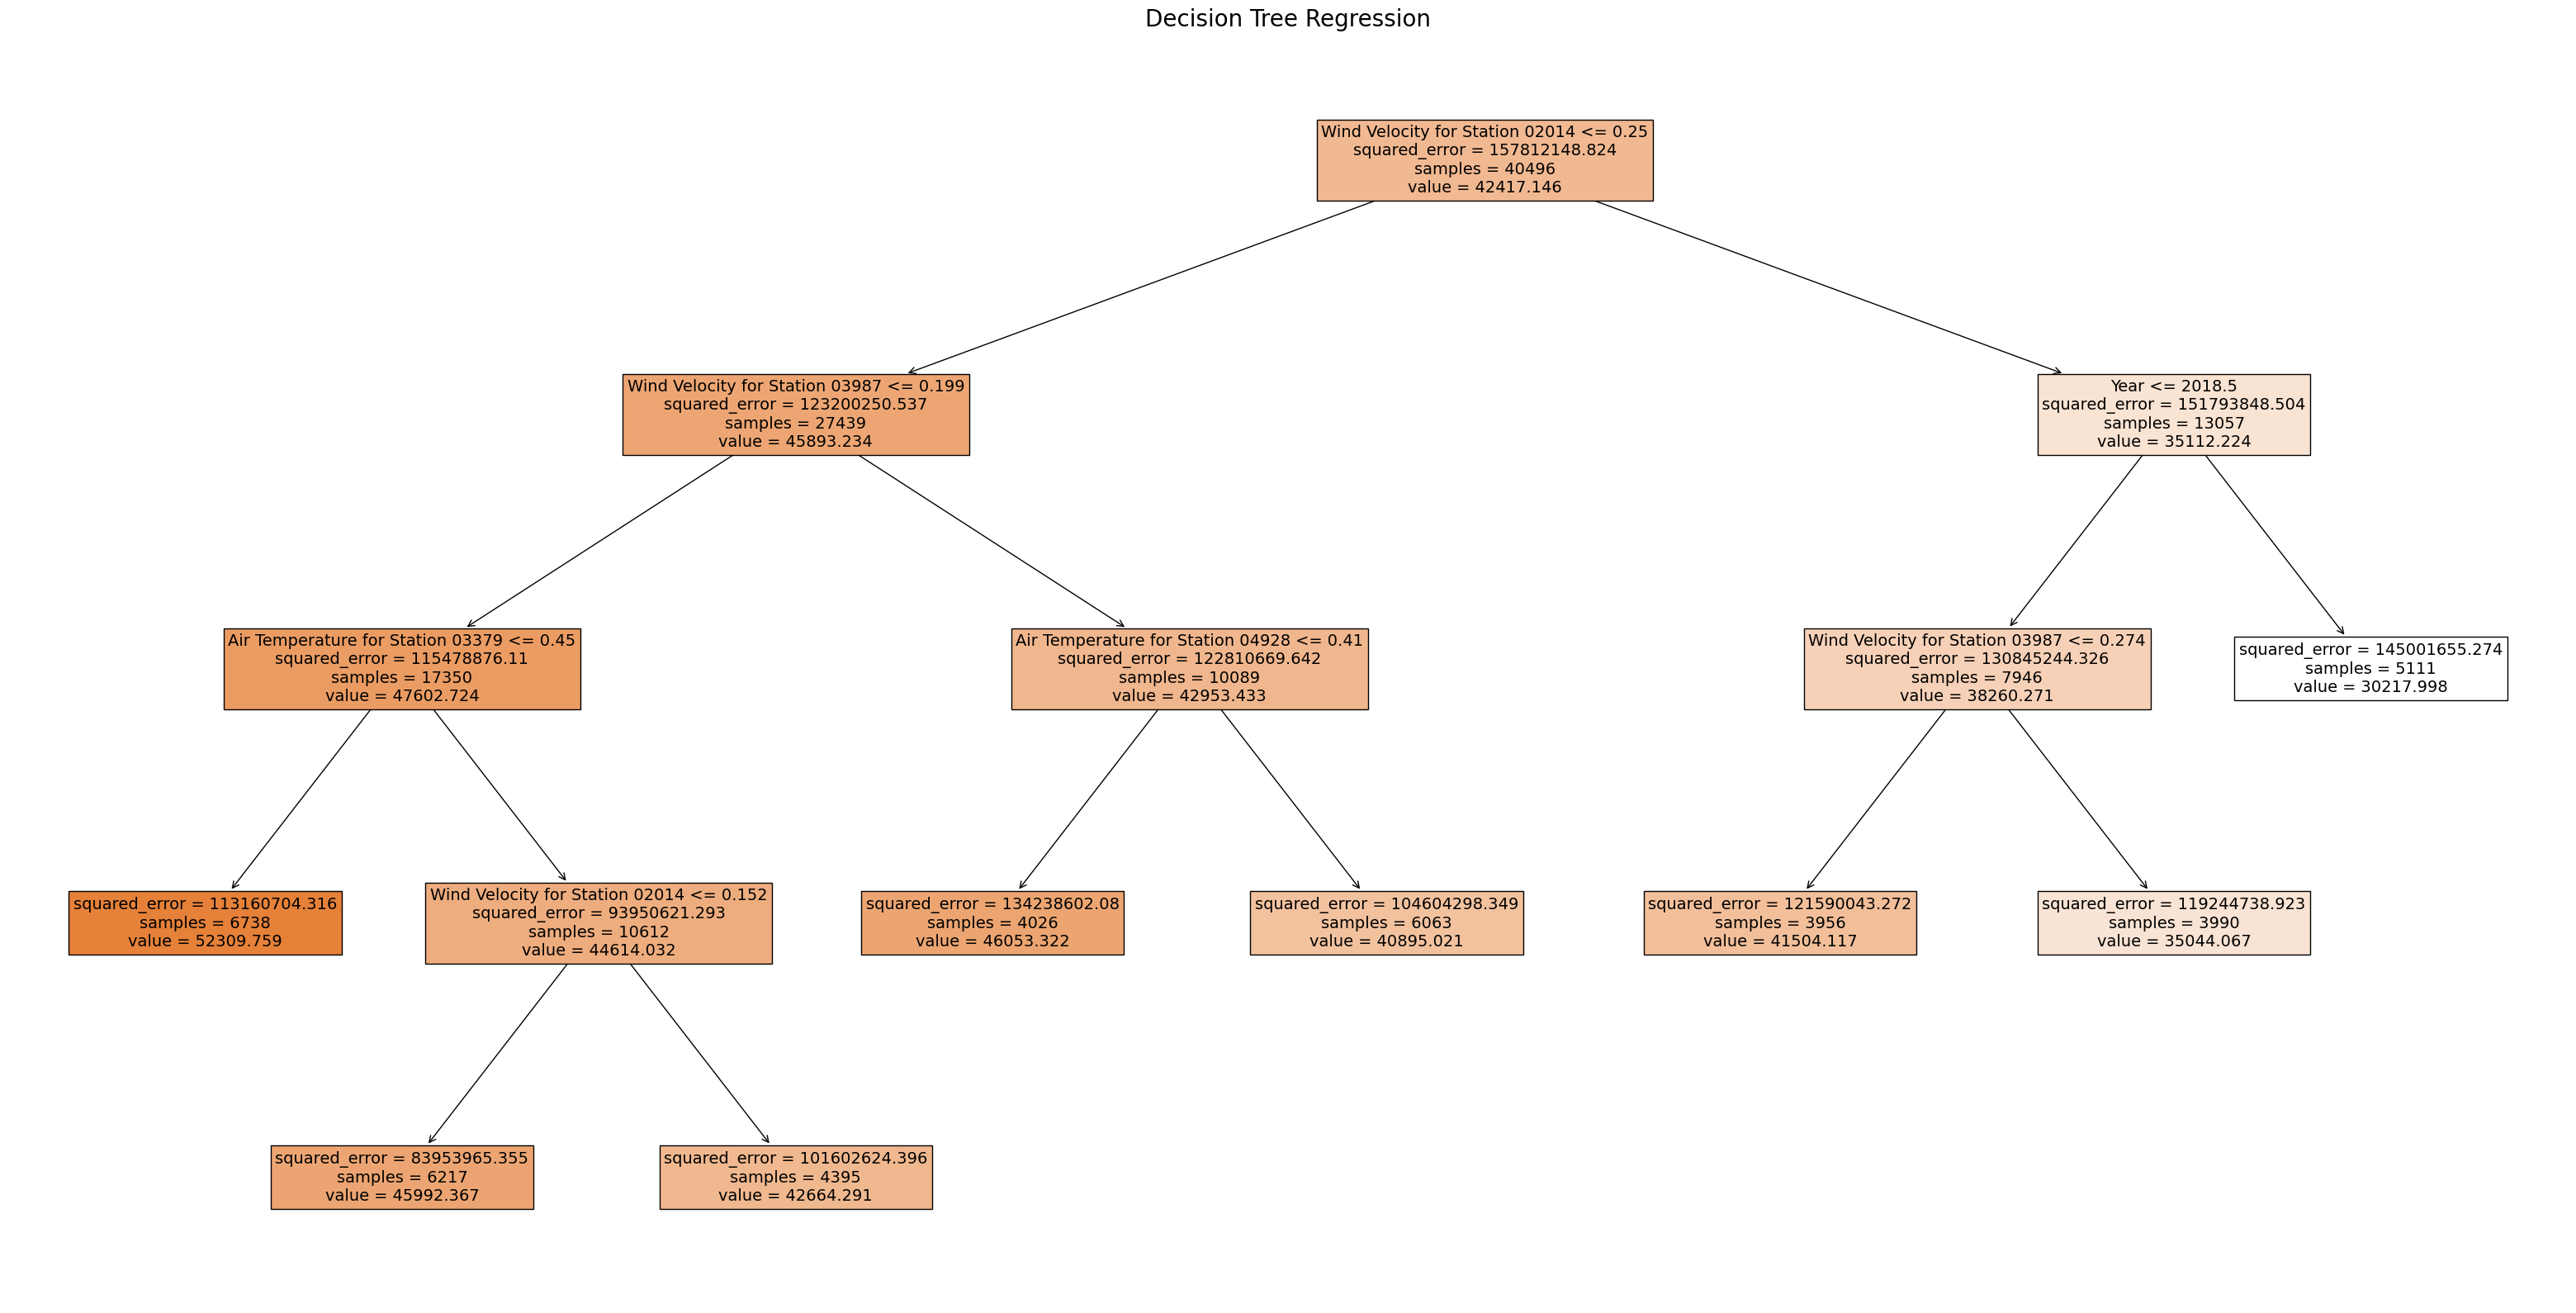

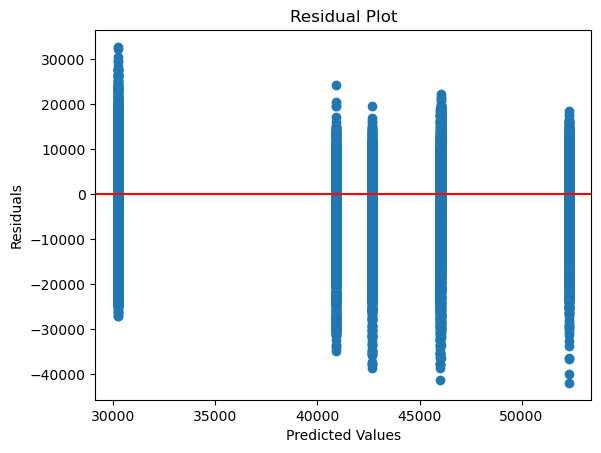

In [76]:
# Get the feature names as a list
feature_names = list(X_train.columns)

# Plot the Decision Tree
plt.figure(figsize=(40,20))
plot_tree(rf, filled=True, feature_names=feature_names, fontsize=14)
plt.title("Decision Tree Regression", fontsize=20)
plt.show()

# Plot the residuals
plt.scatter(y_pred, y_test - y_pred)
plt.axhline(y=0, color='r', linestyle='-')  # Add a horizontal line at y=0
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

### Using TimeSeriesSplit

In [77]:
# Create TimeSeriesSplit instance
tscv = TimeSeriesSplit(n_splits=5)

In [78]:
# Create the DT Regressor
reg = DecisionTreeRegressor(random_state=42)
# Create the RandomizedSearchCV instance
random_search = RandomizedSearchCV(reg,
                                   param_distributions=param_dist,
                                   n_iter=1000,
                                   cv=tscv, # here, we pass TSCV instead of regular CV
                                   random_state=42,
                                   scoring="neg_mean_squared_error")

# perform the hyperparameter optimization
random_search.fit(X_train, y_train)

c:\Users\Babett\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
100 fits failed out of a total of 5000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Babett\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Babett\anaconda3\Lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "c:\Users\Babett\anaconda3\Lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\Babett\anaconda3\Lib\site-pa

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=DecisionTreeRegressor(random_state=42),
                   n_iter=1000,
                   param_distributions={'ccp_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001CB21A12D90>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001C...
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001CB1E290B50>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001CB1F4D9050>,
                                        'min_weight_fraction_leaf': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001CB206A9A90>},
                   random_state=42, scoring='neg_mean_squared_error')

In [79]:
# inspect the model's performance
best_score = random_search.best_score_
rmse = sqrt(-best_score)
print("RMSE: ", rmse)
print("NRMSE: ", rmse / (y_test.max() - y_test.min()))

RMSE:  10958.794202509443
NRMSE:  0.16181074037311288


In [80]:
# inspect the tuned hyperparameters
best_params = random_search.best_params_
best_params

{'ccp_alpha': 0.15041689110352818,
 'max_depth': 6,
 'max_features': 17,
 'max_leaf_nodes': 86,
 'min_impurity_decrease': 0.06351182959000135,
 'min_samples_leaf': 0.03682186763599138,
 'min_samples_split': 0.1338521188006332,
 'min_weight_fraction_leaf': 0.016835982413498644}

In [81]:
# Train the model on the whole dataset and predict unseen data to assess it's real performance
rf = DecisionTreeRegressor(**best_params, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
rmse = sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: ", rmse)
print("NRMSE: ", rmse / (y_test.max() - y_test.min()))

RMSE:  11093.479600694762
NRMSE:  0.1637994212074353


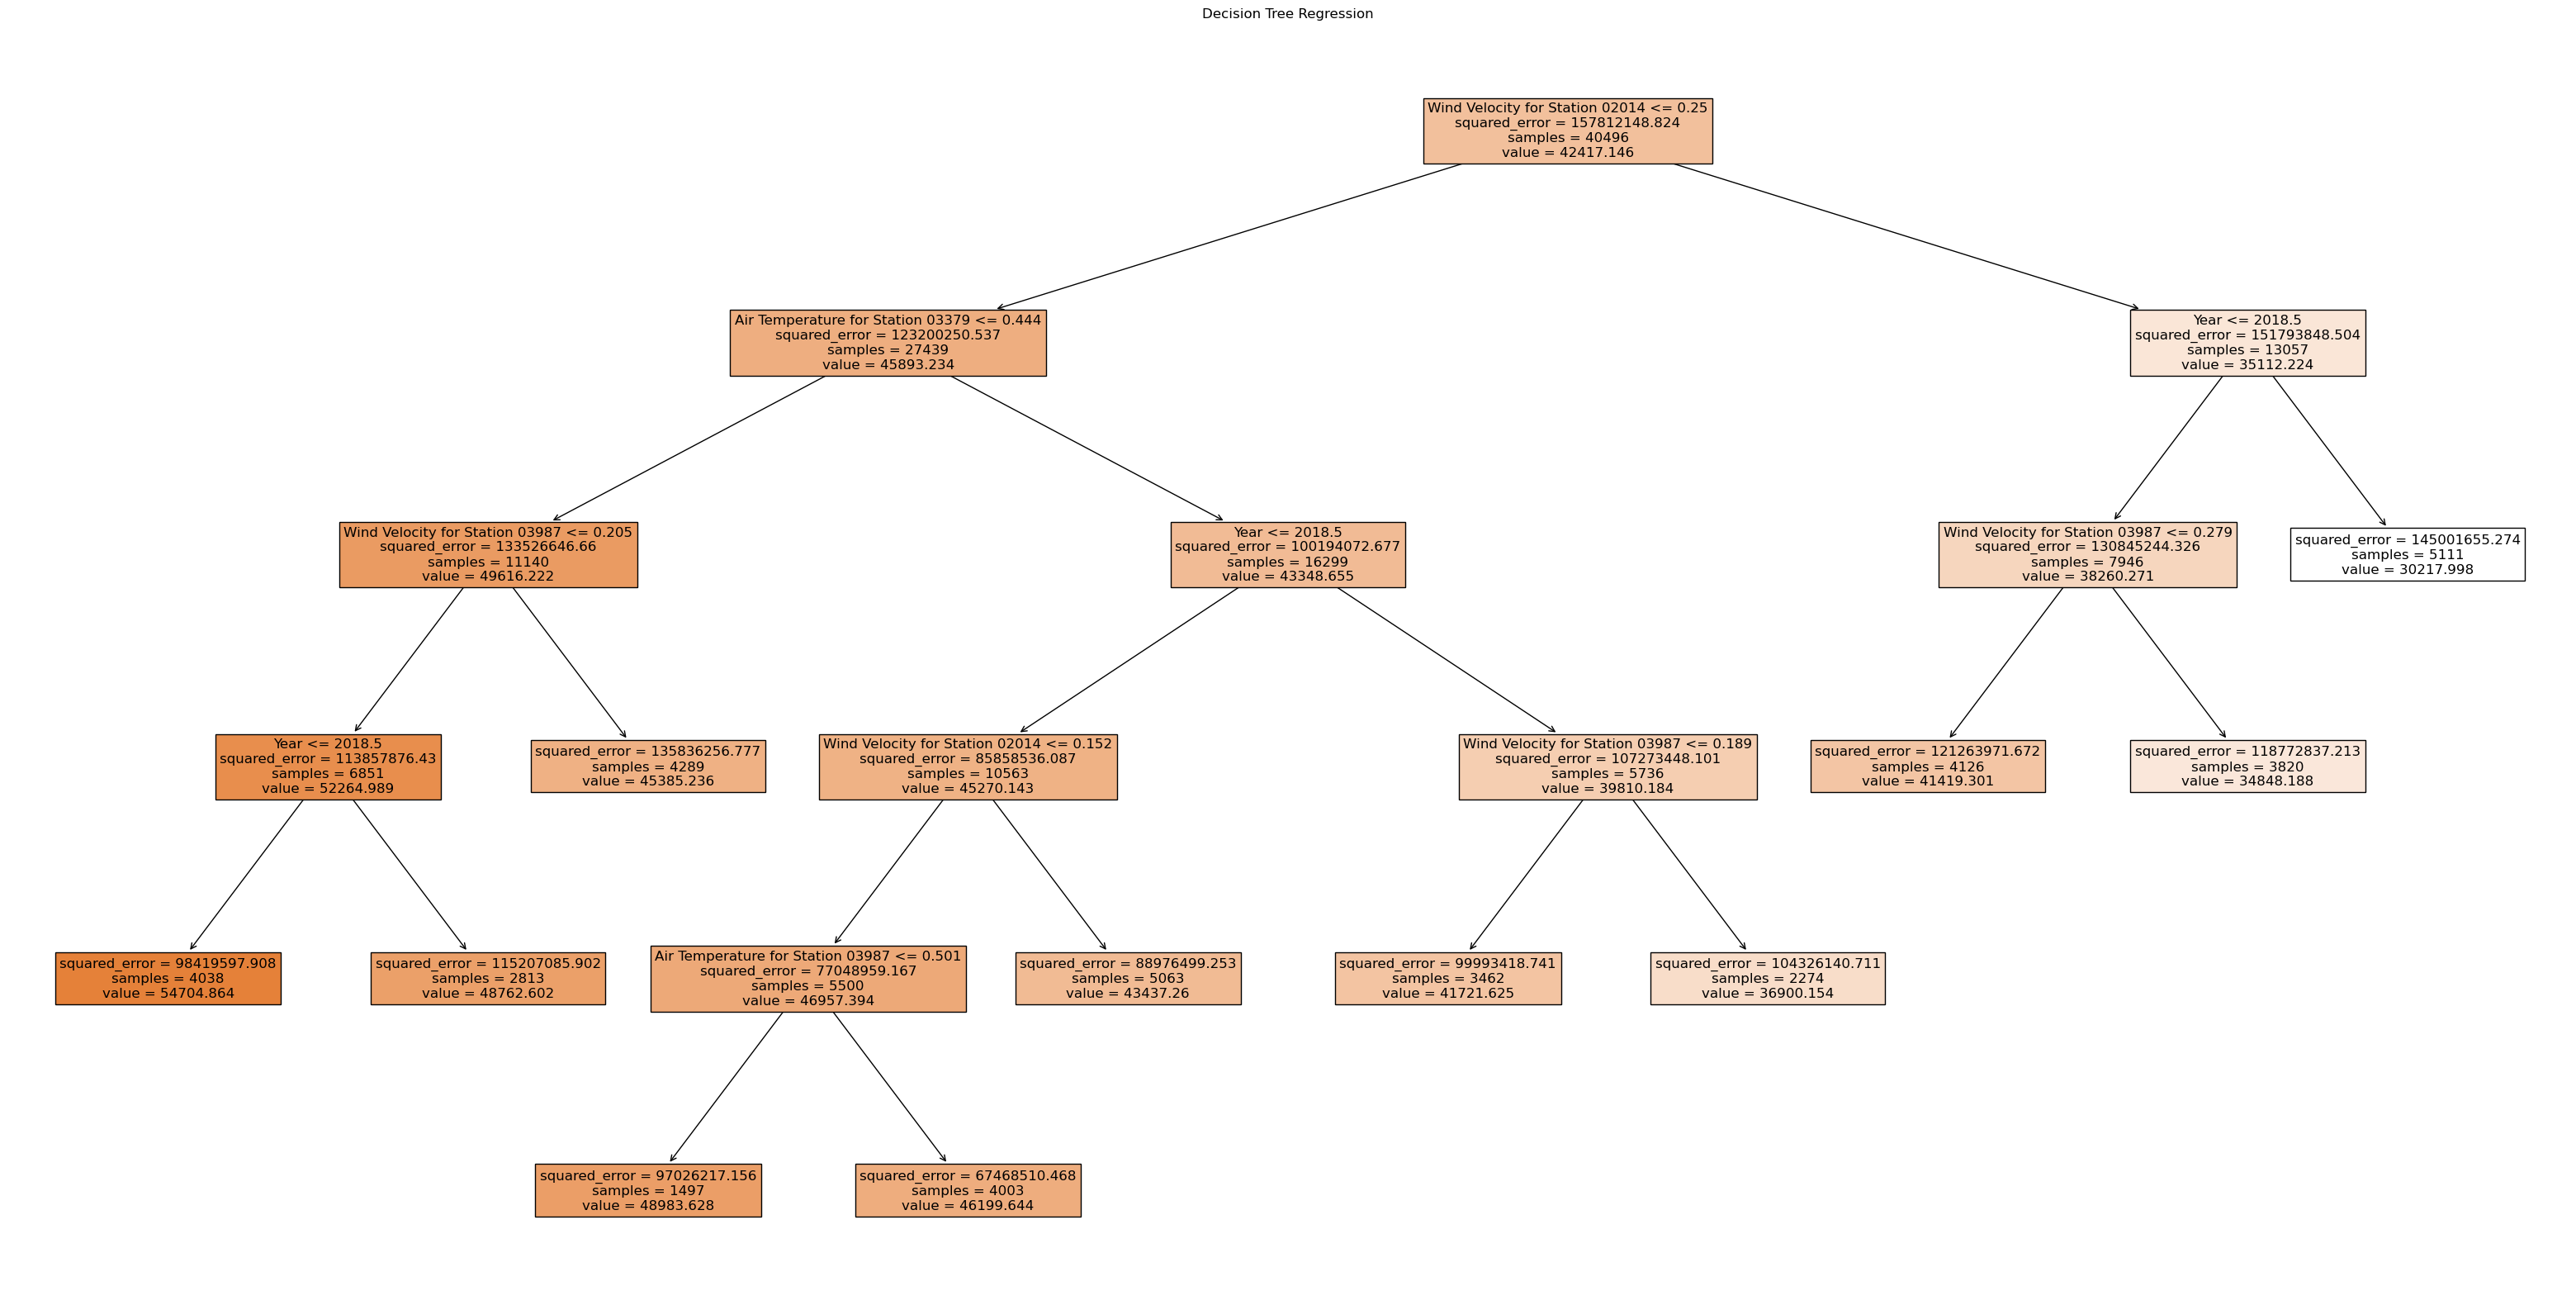

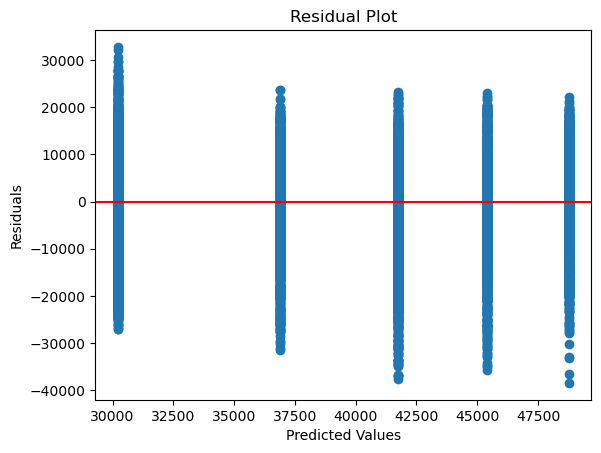

In [82]:
# Get the feature names as a list
feature_names = list(X_train.columns)

# Plot the Decision Tree
plt.figure(figsize=(40,20))
plot_tree(rf, filled=True, feature_names=feature_names, fontsize=12)
plt.title("Decision Tree Regression")
plt.show()

# Plot the residuals
plt.scatter(y_pred, y_test - y_pred)
plt.axhline(y=0, color='r', linestyle='-')  # Add a horizontal line at y=0
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()